# rl_trans.ipynb

This model is meant to illustrate how properly timed transitions can make the reward-modulated Hebbian learning rule a powerful way to implement maximization of a value function. The example in this notebook is a version of rl5E_lite modfied to solve the inverted pendulum problem. To this end the x_netB units are replaced with X_netC units.


In [1]:
%cd ../..
from draculab import *
import numpy as np
import matplotlib.pyplot as plt
import time
from tools.visualization import plotter

/home/z/projects/draculab/notebook


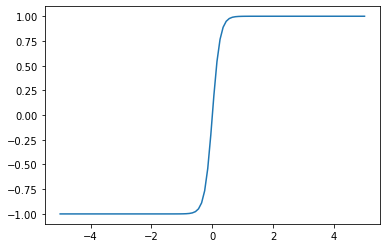

array([0.        , 0.6981317 , 1.3962634 , 2.0943951 , 2.7925268 ,
       3.4906585 , 4.1887902 , 4.88692191, 5.58505361])

In [2]:
t = np.linspace(-5., 5., 100)
x = np.tanh(4.*t)
fig = plt.figure()
plt.plot(t,x)
plt.show()
np.linspace(0., 2.*np.pi, 10)[:-1]

<ipython-input-3-8e982d28defb>:1: RuntimeWarning: divide by zero encountered in arctanh
  y = np.arctanh(x)/4.


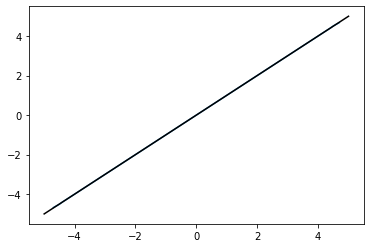

In [3]:
y = np.arctanh(x)/4.
fig2 = plt.figure()
plt.plot(t,y, t, t, 'k')
plt.show()

In [2]:
#===================================================================
#================ CREATE THE NETWORK ===============================
#===================================================================

N = 20 # number of units to represent the angle
#np.random.seed(123456) # always the same random values
np.random.seed()   # different random values ever run


#--------------------------------------------------------------------
# PARAMETER DICTIONARIES
#--------------------------------------------------------------------
net_params = {'min_delay' : 0.005,
              'min_buff_size' : 8 }
# plant parameters
P_params = {'type' : plant_models.pendulum,
            'length' : 0.5,
            'mass' : 1.,
            'init_angle' : 0.,
            'init_ang_vel' : 0.,
            'g' : 9.81,
            'inp_gain' : 2.,
            'mu' : 1.,
            #'delay' : None, # set after V_params
            'bound_angle' : False,} 
# unit parameters
X_params = {'type' : unit_types.x_netC,
            'multidim' : True,
            'init_val' : np.concatenate((np.array([0.5]), 0.1*np.ones(N))),
            'tau' : 0.02,
            'slope' : 5.,
            'lrate' : 50.,
            'trans_t' : 3.,
            'tau_fast' : 0.05,
            'tau_mid' : 0.5,
            'tau_slow' : 50.,
            'delay' : .5, # to enlarge activity buffer
            'N' : N,
            'w_sum' : 10.,
            'normalize' : True,
            's_wid' : 10.,
            'beta' : 2.,
            'refr_per' : 2.,
            'coordinates' : np.array([0.7, 0.3]) }
            
# units to track synaptic weights or other values
track_params = {'type' : unit_types.source,
                'init_val' : 0.02,
                'function' : lambda t: None }

#--------------------------------------------------------------------
# Connection dictionaries
#--------------------------------------------------------------------
# X to plant
X__P_conn = {'inp_ports' : 0,
             'delays': 0.02 }
X__P_syn = {'type': synapse_types.static,
            'init_w' : 1. }
# plant to X
P__X_conn = {'port_map' : [(0,0)],
             'delays' : 0.02 }
P__X_syn = {'type' : synapse_types.static,
            'init_w' : 1. }

#--------------------------------------------------------------------
# CREATING UNITS
#--------------------------------------------------------------------
net = network(net_params)
P = net.create(1, P_params)
X = net.create(1, X_params)

# tracking units
x_track = net.create(N, track_params) # S__X weights

#--------------------------------------------------------------------
# CONNECTING
#--------------------------------------------------------------------
net.set_plant_outputs(P, X, P__X_conn, P__X_syn)
net.set_plant_inputs(X, P, X__P_conn, X__P_syn)

# SETTING UP TRACKING OF X STATE VARIABLES
def x_track_fun(idx):
    return lambda t: net.units[X[0]].buffer[1+idx,-1]
for idx, uid in enumerate(x_track):
    net.units[uid].set_function(x_track_fun(idx))

In [32]:
sim_time = 400.
#ratio = 3. # shiva
ratio = .21 # breaker
secs2finish = sim_time * ratio
lt1 = time.localtime()
hrs, hrs_rem = divmod(secs2finish, 3600)
mins, mns_rem = divmod(hrs_rem, 60)
xtra_hrs, new_mins = divmod(lt1.tm_min+mins, 60)
print("Expecting to finish at: %d:%d (%d seconds)" % 
      (lt1.tm_hour+hrs+xtra_hrs, new_mins, secs2finish))
start_time = time.time()

times, data, plant_data  = net.run(sim_time)

print('Execution time is %s seconds' % (time.time() - start_time))
lt2 = time.localtime
print("Finished at " + time.strftime('%H:%M'))
data = np.array(data)

# import cProfile
# import pstats
# cProfile.run('times, data, plant_data = net.run(2.)', 'restats')
# prof = pstats.Stats('restats')
# prof.sort_stats('cumulative').print_stats(30)
# data = np.array(data

Expecting to finish at: 17:40 (84 seconds)
Execution time is 78.10523176193237 seconds
Finished at 17:40


In [33]:
print(net.units[X[0]].hp)
print(net.units[X[0]].lst_hp)

3.977762134708648e-06
0.0


In [34]:
net.units[X[0]].lst

668.5649999994645

Text(0.5, 1.0, 'X--P weights')

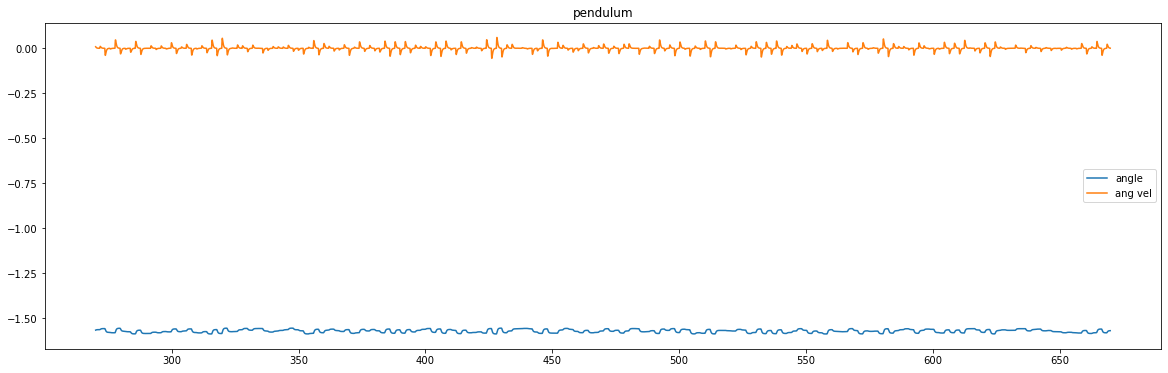

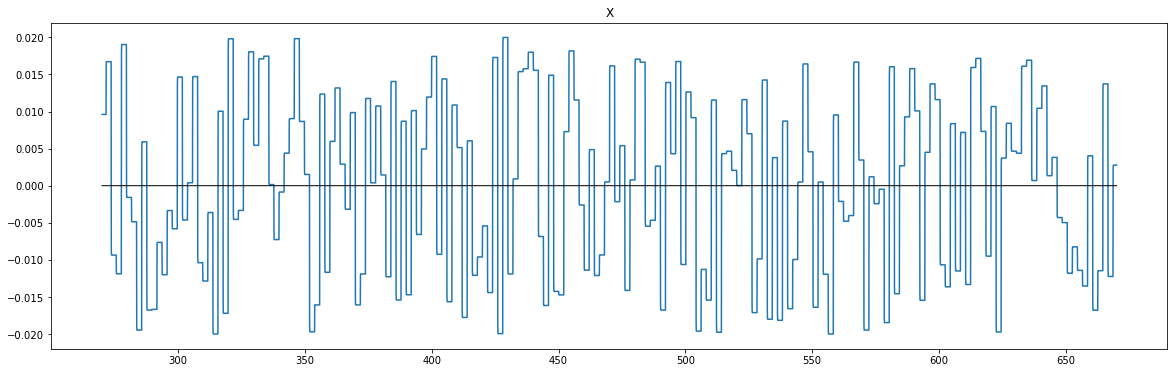

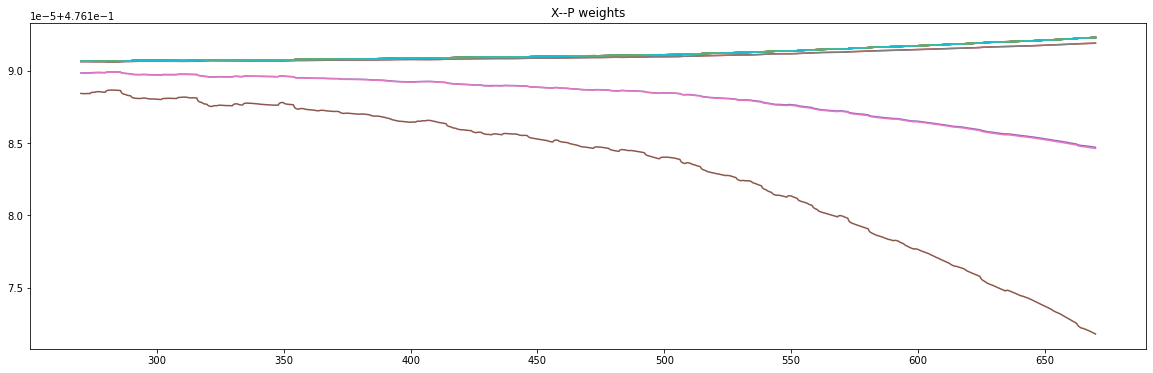

In [35]:
fs = (20,6)

# P
P_fig = plt.figure(figsize=fs)
#P_data = np.mod(plant_data[P], 2.*np.pi)
P_data = plant_data[P]
plt.plot(times, P_data[:,0], label='angle')
plt.plot(times, P_data[:,1], label='ang vel')
plt.legend()
plt.title('pendulum')
#print("angle: %f, vel: %f" % (P_data[-1,0],P_data[-1,1]))

# X
X_fig = plt.figure(figsize=fs)
X_data = np.array(data[X])
plt.plot(times, X_data.transpose())
plt.plot(times, np.zeros(len(times)), 'k', linewidth=1)
#plt.ylim([-0.05,1.05])
#plt.legend(['X'])
plt.title('X')

# X--P weights
W_fig = plt.figure(figsize=fs)
w_track_data = np.array(data[x_track])
plt.plot(times, w_track_data.transpose())
plt.title('X--P weights')


In [36]:
# Testing amount of change in the weights
print("Maximum minus minimum, X:")
print(max(net.units[X[0]].buffer[1:,-1]) - min(net.units[X[0]].buffer[1:,-1]))

print("\nSum of S--X weights")
print(np.abs(net.units[X[0]].buffer[1:,-1]).sum())

Maximum minus minimum, X:
2.0498579135774797e-05

Sum of S--X weights
9.523809523809511


In [37]:
net.units[X[0]].buffer[1:,-1]

array([0.4761923 , 0.4761923 , 0.4761923 , 0.4761923 , 0.4761923 ,
       0.4761923 , 0.4761923 , 0.4761923 , 0.4761923 , 0.4761923 ,
       0.4761923 , 0.4761923 , 0.4761923 , 0.47619191, 0.47618471,
       0.47617181, 0.47618463, 0.47619191, 0.4761923 , 0.4761923 ])

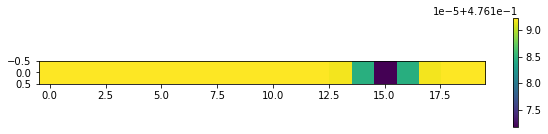

In [38]:
weights = net.units[X[0]].buffer[1:,-1]
d_fig = plt.figure(figsize=(10,2))
d_ax = plt.subplot(1,1,1)
cs = d_ax.imshow(weights.reshape(1,N))
d_fig.colorbar(cs)
plt.show()

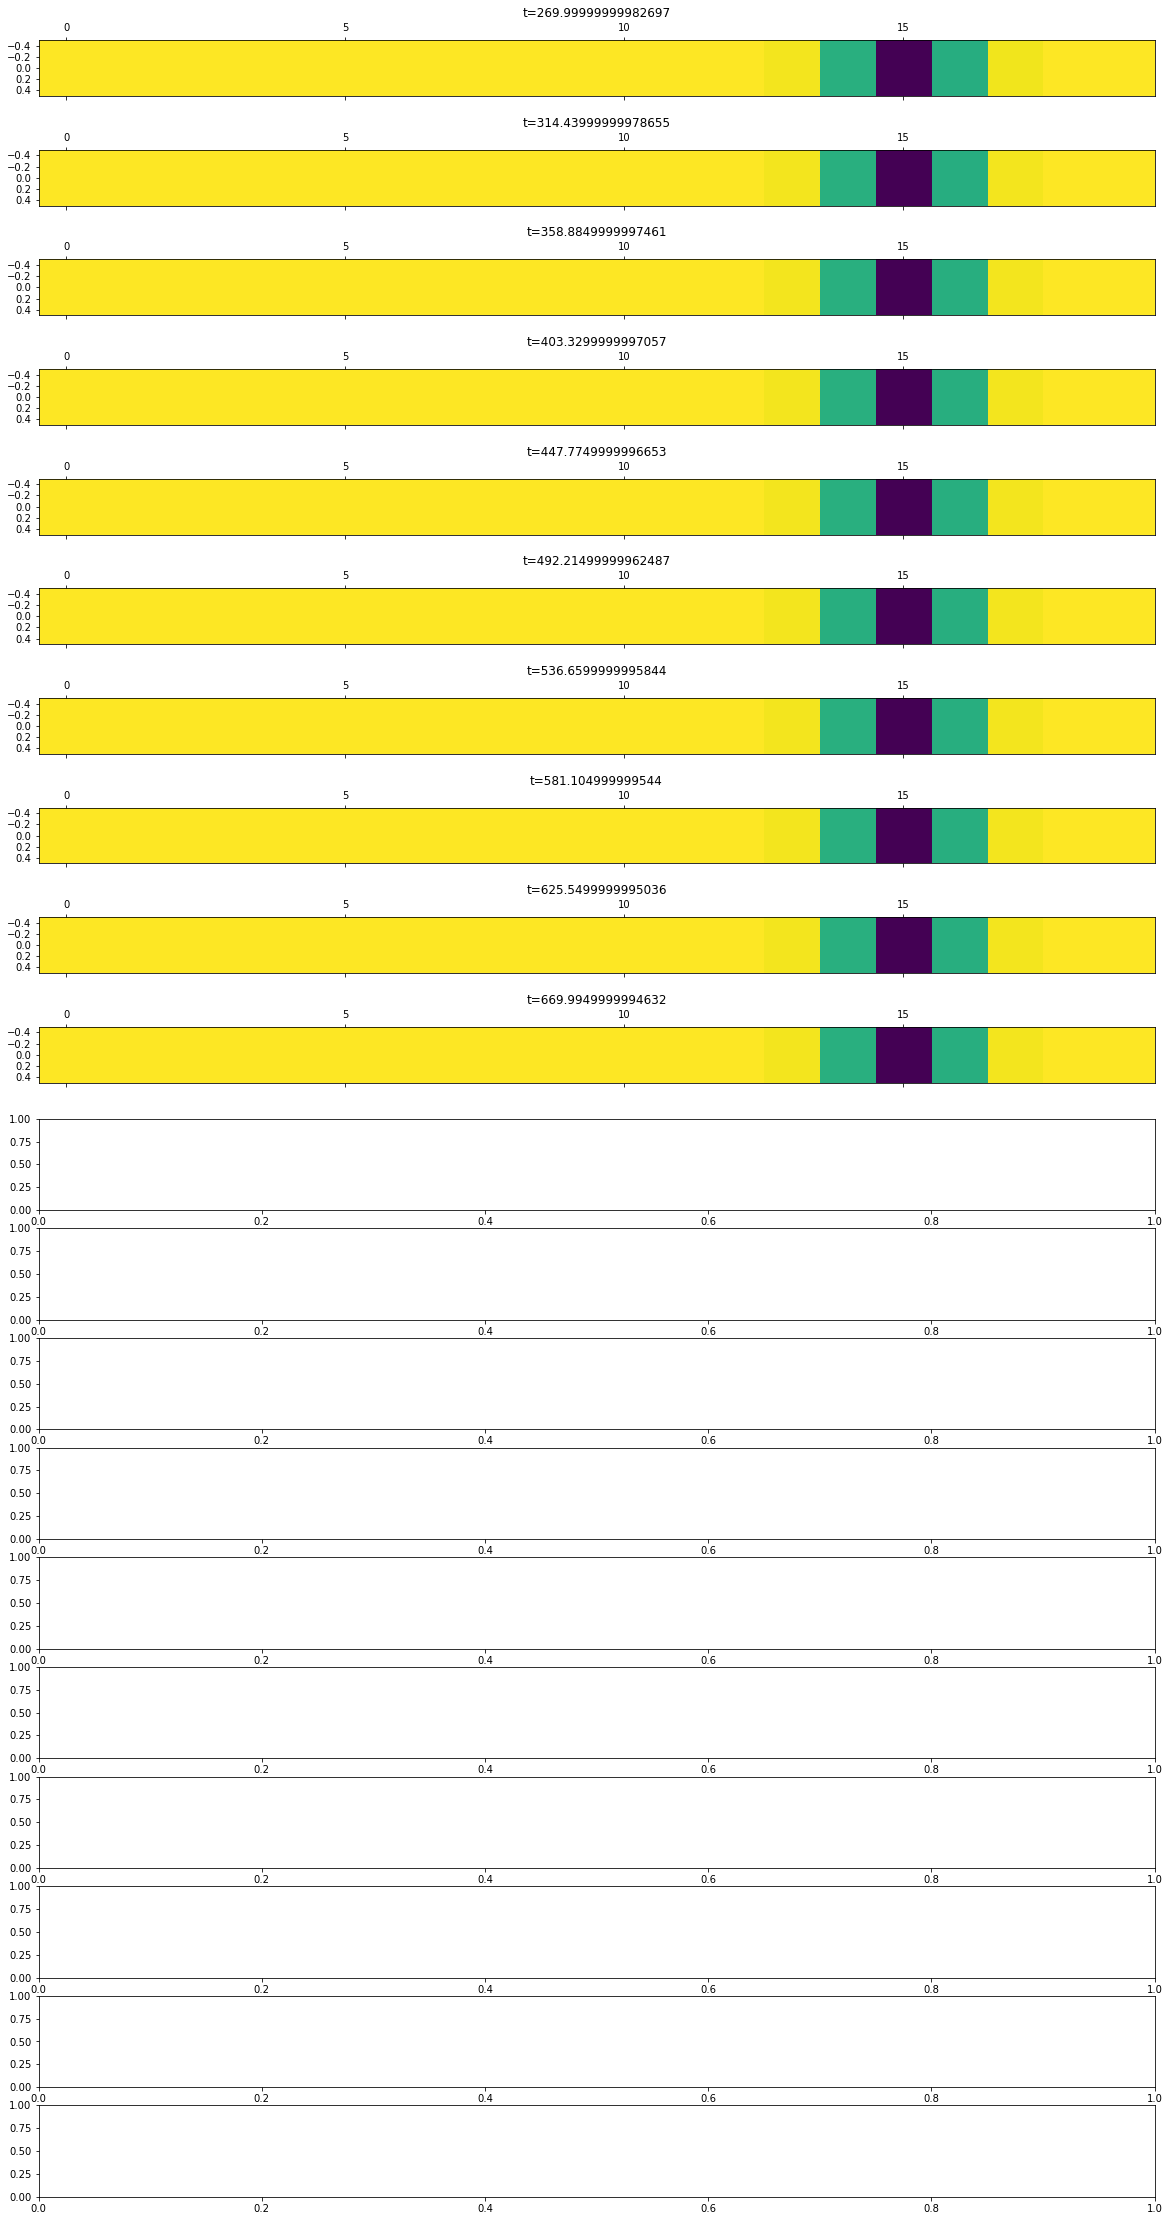

In [39]:
# Visualize S__X weights
n_plots = 10 # number of plots, each at a different time
n_rows = 20
n_cols = 1
t_idxs = [int(i) for i in np.linspace(0, len(times)-1, n_plots)]

S__X_fig, S__X_axs = plt.subplots(n_rows, n_cols, figsize=(fs[0], n_rows*fs[1]/3))
for i_plot in range(n_plots):
    row, col = np.divmod(i_plot, n_cols)
    ax = S__X_axs[row]
    cs = ax.matshow(data[x_track][:,t_idxs[i_plot]].reshape(1,N))
    ax.set_title('t='+str(times[t_idxs[i_plot]]))
    
plt.show()

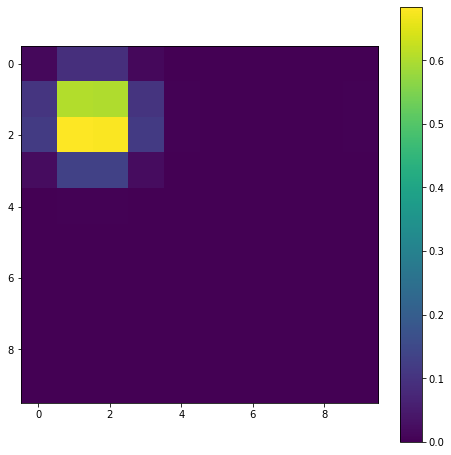

In [76]:
L_out_fig = plt.figure(figsize=(8,8))
axs = plt.subplot(1,1,1)
cs = axs.imshow(net.units[V[0]].L_out_copy.reshape(10,10))
L_out_fig.colorbar(cs)
plt.show()

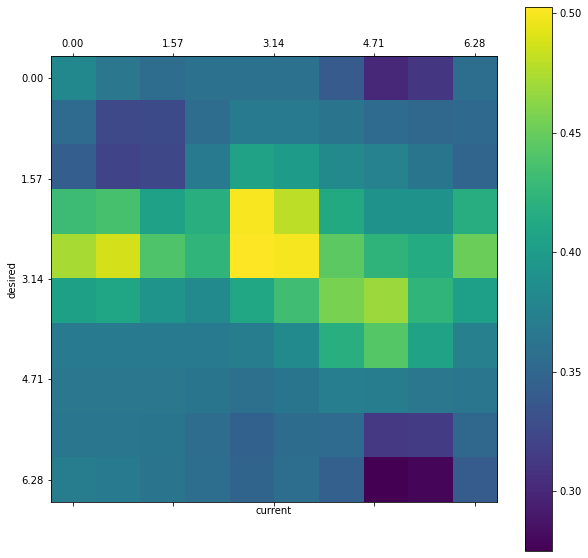

In [11]:
net.units[V[0]].buffer[1:,-1]
d_fig = plt.figure(figsize=(10,10))
d_ax = plt.subplot(1,1,1)
cs = d_ax.matshow(net.units[X[0]].buffer[1:,-1].reshape(10,10))
d_fig.colorbar(cs)
d_ax.set_ylabel('desired')
d_ax.set_xlabel('current')
ticks = np.linspace(0.,9,5)
labels = ['{:.2f}'.format(i) for i in np.linspace(0.,2.*np.pi,5)]
d_ax.set_xticks(ticks)
d_ax.set_xticklabels(labels)
d_ax.set_yticks(ticks)
d_ax.set_yticklabels(labels)
plt.show()

In [48]:
net.units[V[0]].L_out_copy.sum()

3.5716123740244305

In [18]:
net.units[SP[0]].set_function(lambda t: des_sf[int(round(t/15.))])

In [34]:
# reducing the scope of the plots
data_back = data
times_back = times
plant_data_back = [np.array([])]
plant_data_back[0] = plant_data[0]

first_idx=500*200
second_idx=600*200
times = times[first_idx:second_idx]
data = data[:, first_idx:second_idx]
plant_data[0] = plant_data[0][first_idx:second_idx,:]

In [10]:
# recover the data
data = data_back
plant_data[0] = plant_data_back[0]
times = times_back

In [21]:
# Storing the M__C and A__M connections
M__C_mat = np.zeros((2,2)) # rows are target (C) neurons
for m_idx, m_id in enumerate(M):
    for c_idx, c_id in enumerate(C):
        syn_list = net.syns[c_id]
        for syn in syn_list:
            if syn.preID == m_id:
                M__C_mat[c_idx, m_idx] = syn.w
                break
                
A__M_mat = np.zeros((2,4)) # rows are target (M) neurons
for a_idx, a_id in enumerate(A):
    for m_idx, m_id in enumerate(M):
        syn_list = net.syns[m_id]
        for syn in syn_list:
            if syn.preID == a_id:
                A__M_mat[m_idx, a_idx] = syn.w
                break
print(M__C_mat)
print(A__M_mat)

[[1.68646211e-07 2.08082448e+00]
 [2.08121483e+00 1.56862359e-07]]
[[0.34878441 0.25118419 0.16842648 0.13160544]
 [0.12283056 0.08501225 0.43893599 0.25322015]]


In [7]:
plotty = plotter(net, times, data)

In [12]:
plotty.act_anim(S1+S2+L+R+V, 0.5, interv=10, slider=False)

In [8]:
plotty.conn_anim(L, V)

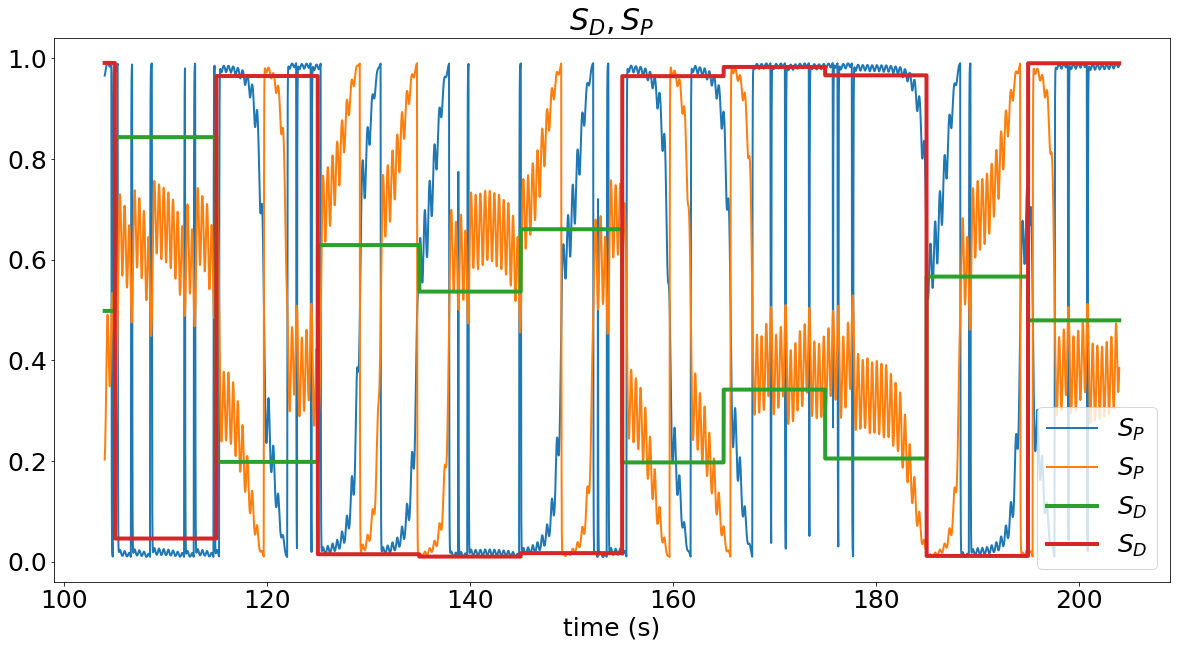

In [18]:
# A figure with more formatting
SPF_fig = plt.figure(figsize=(20,10))
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
plt.plot(times, SF_data.transpose(), label='$S_P$', linewidth=2)
plt.plot(times, SP_data.transpose(), label='$S_D$', linewidth=4)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25)
plt.xlabel('time (s)', fontsize =25)
plt.title('$S_D, S_P$', fontsize=30)
plt.show()

In [4]:
# good initial weights

# M__C
# M[0] has the F-D error, so you want C[0] (which exerts positive torque)
# to be driven by M[1] instead, and C[1] to be driven by M[0]
shift = 0
while not net.syns[C[0]][shift].type is synapse_types.rga:
    shift += 1
net.syns[C[0]][shift].w = 0.1
net.syns[C[0]][shift+1].w = 0.8 # C[0] driven by M[1]
net.syns[C[1]][shift].w = 0.8
net.syns[C[1]][shift+1].w = 0.1

# L__X, L__V
scale = 1. # maximum weight value
def dist(c1, c2):
    """ Periodic distance between 2-dim coordinates c1 and c2. 

        Assumes c1 and c2 are inside the box with corners [-0.5, -0.5], [0.5, 0.5].
    """
    x_dist = min(max(c1[0], c2[0]) - min(c1[0], c2[0]),  # "inner" distance
                 0.5-max(c1[0], c2[0]) + (min(c1[0], c2[0])+0.5) ) # "outer" distance
    y_dist = min(max(c1[1], c2[1]) - min(c1[1], c2[1]),  # "inner" distance
                 0.5-max(c1[1], c2[1]) + (min(c1[1], c2[1])+0.5) ) # "outer" distance
    return np.sqrt(x_dist*x_dist + y_dist*y_dist)

#L__V_iw = np.zeros((No2, No2))
j = 0
for i in range(len(L)):  # Setting L__V weights
    u = net.units[L[i]]
    c = u.coordinates
    d = dist(c, [c[1], c[1]])
    Vsyn = net.syns[V[0]][i]
    Xsyn = net.syns[X[0]][i+j]
    while Xsyn.type != synapse_types.diff_rm_hebbian:
        j +=1
        Xsyn = net.syns[X[0]][i+j]
    if Vsyn.preID == u.ID and Xsyn.preID == u.ID:
        a, b = divmod(i, No2)
        Vsyn.w = scale*(.5 - d)
        Xsyn.w = 0.01 if abs(c[1]-c[0]) < 0.5-max(c[1],c[0]) + min(c[1],c[0])+0.5 else .8
    else:
        print("FAILED!!!!!!!")

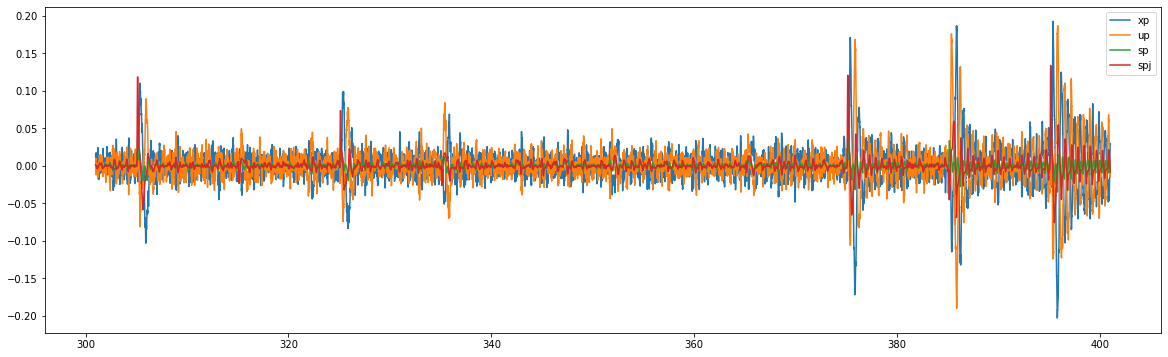

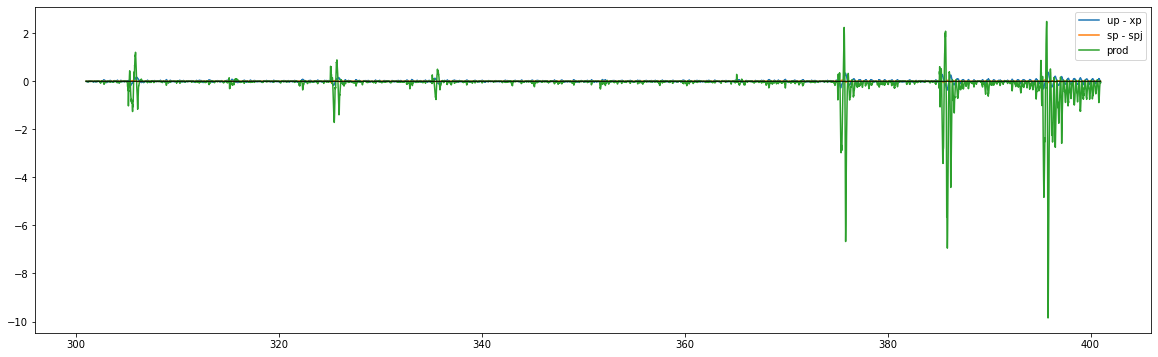

In [20]:
# plot all factors in the M--C0 synaptic plasticity
fs = (20,6)
plastic_fig = plt.figure(figsize=fs)
xp_data = np.array(data[xp_track[0]])
up_data = np.array(data[up_track[0]])
sp_data = np.array(data[sp_track[0]])
spj_data = np.array(data[spj_track[0]])
plt.plot(times, xp_data)
plt.plot(times, up_data)
plt.plot(times, sp_data)
plt.plot(times, spj_data)
plt.legend(['xp', 'up', 'sp', 'spj'])

plastic_fig2 = plt.figure(figsize=fs)
f1 = up_data - xp_data
f2 = sp_data - spj_data
rule = 500. * f1 * f2
plt.plot(times, f1)
plt.plot(times, f2)
plt.plot(times, rule)
plt.plot(times, np.zeros(len(times)), 'k', linewidth=1)
plt.legend(['up - xp', 'sp - spj', 'prod'])
plt.show()

In [11]:
# checking some connections
print("Connections to M0 unit")
for idx, syn in enumerate(net.syns[M[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    #elif pre_id in L:
    #    pre_pop = 'L'
    elif pre_id in M:
        pre_pop = 'M'
    #elif pre_id in V:
    #    pre_pop = 'V'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> M0, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

print("Connections to M1 unit")
for idx, syn in enumerate(net.syns[M[1]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    #elif pre_id in L:
    #    pre_pop = 'L'
    elif pre_id in M:
        pre_pop = 'M'
    #elif pre_id in V:
    #    pre_pop = 'V'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> M1, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
    
print("Connections to C0 unit")
for idx, syn in enumerate(net.syns[C[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in C:
        pre_pop = 'C'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> C0, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))  

print("Connections to C1 unit")
for idx, syn in enumerate(net.syns[C[1]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in C:
        pre_pop = 'C'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> C1, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))  

    
print("Connections to afferent units")
for idx, syn in enumerate(net.syns[A[2]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> A, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

print("Connections to plant")
for idx, syn in enumerate(net.plants[P].inp_syns[0]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in C:
        pre_pop = 'C'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d, %s) --> P, w=%f'%(idx, pre_pop, pre_id, pre_type, syn.w))
    
print("Connections to MPLEX units")
for idx, syn in enumerate(net.syns[MPLEX[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in X:
        pre_pop = 'X'
    elif pre_id in SF:
        pre_pop = 'SF'
    elif pre_id in SP:
        pre_pop = 'SP'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> MPLEX, w=%f, port=%d'%(idx, pre_pop, pre_id, syn.w, syn.port))  

print("Connections to SF units")
for idx, syn in enumerate(net.syns[SF[1]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in T:
        pre_pop = 'T'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> SF, w=%f, port=%d, plant_out=%s'%
          (idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

print("Connections to X unit")
for idx, syn in enumerate(net.syns[X[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in V:
        pre_pop = 'V'
    elif pre_id in MPLEX:
        pre_pop = 'MPLEX'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> X, w=%f, port=%d'%(idx, pre_pop, pre_id, syn.w, syn.port))  
    
print("Connections to V unit")
for idx, syn in enumerate(net.syns[V[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in MPLEX:
        pre_pop = 'MPLEX'
    elif pre_id in R:
        pre_pop = 'R'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> V, w=%f, port=%d'%(idx, pre_pop, pre_id, syn.w, syn.port))  


Connections to M0 unit
0) A (0) --> M0, w=0.219605, port=2, plant_out=None
1) A (1) --> M0, w=0.248533, port=2, plant_out=None
2) A (2) --> M0, w=0.224219, port=2, plant_out=None
3) A (3) --> M0, w=0.207640, port=2, plant_out=None
4) M (107) --> M0, w=-1.000000, port=3, plant_out=None
5) SPF (155) --> M0, w=1.000000, port=1, plant_out=None
Connections to M1 unit
0) A (0) --> M1, w=0.252435, port=2, plant_out=None
1) A (1) --> M1, w=0.167266, port=2, plant_out=None
2) A (2) --> M1, w=0.215700, port=2, plant_out=None
3) A (3) --> M1, w=0.264603, port=2, plant_out=None
4) M (106) --> M1, w=-1.000000, port=3, plant_out=None
5) SPF (156) --> M1, w=1.000000, port=1, plant_out=None
Connections to C0 unit
0) C (5) --> C0, w=-1.500000, port=1, plant_out=None
1) M (106) --> C0, w=0.014658, port=0, plant_out=None
2) M (107) --> C0, w=2.066072, port=0, plant_out=None
Connections to C1 unit
0) C (4) --> C1, w=-1.500000, port=1, plant_out=None
1) M (106) --> C1, w=2.066016, port=0, plant_out=None
2)

In [23]:
# running in two stages. Initial high learning rate and viscosity.
sim_time = 150.
#ratio = 15.1 # cns-amd
#ratio = 20. # breaker
ratio = 1.6 # breaker, no L,V
secs2finish = sim_time * ratio
lt1 = time.localtime()
hrs, hrs_rem = divmod(secs2finish, 3600)
mins, mns_rem = divmod(hrs_rem, 60)
xtra_hrs, new_mins = divmod(lt1.tm_min+mins, 60)
print("Expecting to finish firstst simulation at %d:%d (%d seconds)" % 
      (lt1.tm_hour+hrs+xtra_hrs, new_mins, secs2finish))
start_time = time.time()

times, data, plant_data  = net.run(sim_time)

print('Initial execution time is %s seconds' % (time.time() - start_time))
lt2 = time.localtime
print("Finished at " + time.strftime('%H:%M'))
data = np.array(data)

sim_time = 100.
net.plants[0].mu = 0.5
for i in [0,1]:
    for syn in net.syns[C[i]]:
        if syn.type == 'rga_21':
            syn.lrate = 100.
            syn.alpha = syn.lrate * net.min_delay

secs2finish = sim_time * ratio
lt1 = time.localtime()
hrs, hrs_rem = divmod(secs2finish, 3600)
mins, mns_rem = divmod(hrs_rem, 60)
xtra_hrs, new_mins = divmod(lt1.tm_min+mins, 60)
print("Expecting to finish at: %d:%d (%d seconds)" % 
      (lt1.tm_hour+hrs+xtra_hrs, new_mins, secs2finish))
start_time = time.time()

times, data, plant_data  = net.run(sim_time)

print('Second execution time is %s seconds' % (time.time() - start_time))
lt2 = time.localtime
print("Finished at " + time.strftime('%H:%M'))
data = np.array(data)

Expecting to finish firstst simulation at 17:23 (240 seconds)


KeyboardInterrupt: 

---